In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np

from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score
import numpy as np

In [14]:
# Define Dataset Class
class CSVDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)

        # Handle missing values
        self.data.fillna(self.data.mean(), inplace=True)

        # Separate features and labels
        self.features = self.data.iloc[:, 1:]
        self.labels = self.data.iloc[:, 0].astype(int)

        # Normalize features
        scaler = StandardScaler()
        self.features = pd.DataFrame(scaler.fit_transform(self.features), columns=self.features.columns)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.features.iloc[idx].values.astype(np.float32)
        label = int(self.labels.iloc[idx])
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

from collections import Counter
torch.manual_seed(42)
csv_file = "merged.csv"  # Replace with your file path
dataset = CSVDataset(csv_file)

# Train-test split
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)



In [39]:
# Example Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Filter training data to only include majority class
majority_class_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 0]  # 0 is the majority class
train_majority_dataset = torch.utils.data.Subset(train_dataset, majority_class_indices)

# Update the DataLoader to use only majority class
train_loader = DataLoader(train_majority_dataset, batch_size=32, shuffle=True)

minority_class_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 1]  # 0 is the majority class
minority_dataset = torch.utils.data.Subset(train_dataset, minority_class_indices)
minority_loader = DataLoader(minority_dataset, batch_size=32, shuffle=True)

# Initialize Autoencoder
input_dim = len(dataset[0][0])  # Number of features
autoencoder = Autoencoder(input_dim)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training Loop
epochs = 100
for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0
    for features, _ in train_loader:  # Labels are not used for unsupervised tasks
        optimizer.zero_grad()
        reconstructed = autoencoder(features)
        loss = criterion(reconstructed, features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}")

# # Evaluate Reconstruction Error on Eval Set
# autoencoder.eval()
# with torch.no_grad():
#     reconstruction_errors = []
#     for features, _ in eval_loader:
#         reconstructed = autoencoder(features)
#         errors = torch.mean((features - reconstructed) ** 2, dim=1).numpy()
#         reconstruction_errors.extend(errors)

Epoch [1/100], Loss: 0.9622
Epoch [2/100], Loss: 0.8123
Epoch [3/100], Loss: 0.6911
Epoch [4/100], Loss: 0.6086
Epoch [5/100], Loss: 0.5528
Epoch [6/100], Loss: 0.5145
Epoch [7/100], Loss: 0.4752
Epoch [8/100], Loss: 0.4628
Epoch [9/100], Loss: 0.4298
Epoch [10/100], Loss: 0.4018
Epoch [11/100], Loss: 0.3787
Epoch [12/100], Loss: 0.3612
Epoch [13/100], Loss: 0.3441
Epoch [14/100], Loss: 0.3287
Epoch [15/100], Loss: 0.3215
Epoch [16/100], Loss: 0.3155
Epoch [17/100], Loss: 0.3132
Epoch [18/100], Loss: 0.3027
Epoch [19/100], Loss: 0.2982
Epoch [20/100], Loss: 0.2906
Epoch [21/100], Loss: 0.2872
Epoch [22/100], Loss: 0.2811
Epoch [23/100], Loss: 0.2755
Epoch [24/100], Loss: 0.2709
Epoch [25/100], Loss: 0.2653
Epoch [26/100], Loss: 0.2624
Epoch [27/100], Loss: 0.2545
Epoch [28/100], Loss: 0.2527
Epoch [29/100], Loss: 0.2488
Epoch [30/100], Loss: 0.2429
Epoch [31/100], Loss: 0.2360
Epoch [32/100], Loss: 0.2302
Epoch [33/100], Loss: 0.2266
Epoch [34/100], Loss: 0.2217
Epoch [35/100], Loss: 0

In [51]:
# Compute Reconstruction Errors for Training and Evaluation Data
autoencoder.eval()
train_errors = []
eval_errors = []

with torch.no_grad():
    for features, _ in train_loader:
        reconstructed = autoencoder(features)
        errors = torch.mean((features - reconstructed) ** 2, dim=1).numpy()
        train_errors.extend(errors)
    
    for features, labels in eval_loader:
        reconstructed = autoencoder(features)
        errors = torch.mean((features - reconstructed) ** 2, dim=1).numpy()
        eval_errors.extend(errors)

# Set Threshold Based on Training Errors (e.g., 95th percentile)
threshold = np.percentile(train_errors, 90)
print(f"Threshold for anomaly detection: {threshold:.4f}")

# Classify Evaluation Data Based on Threshold
eval_labels = []
predicted_labels = []

with torch.no_grad():
    for features, labels in eval_loader:
        reconstructed = autoencoder(features)
        errors = torch.mean((features - reconstructed) ** 2, dim=1).numpy()
        preds = (errors > threshold).astype(int)  # 1 for anomaly, 0 for normal
        eval_labels.extend(labels.numpy())
        predicted_labels.extend(preds)

# Generate Classification Report
print("Classification Report:")
print(classification_report(eval_labels, predicted_labels, target_names=["Class 0 (Normal)", "Class 1 (Anomaly)"]))

# Evaluate Precision-Recall and AUC
precision, recall, _ = precision_recall_curve(eval_labels, eval_errors)
pr_auc = roc_auc_score(eval_labels, eval_errors)

print(f"Precision-Recall AUC: {pr_auc:.4f}")


Threshold for anomaly detection: 0.2202
Classification Report:
                   precision    recall  f1-score   support

 Class 0 (Normal)       0.95      0.88      0.91       271
Class 1 (Anomaly)       0.30      0.52      0.38        27

         accuracy                           0.85       298
        macro avg       0.63      0.70      0.65       298
     weighted avg       0.89      0.85      0.87       298

Precision-Recall AUC: 0.7632


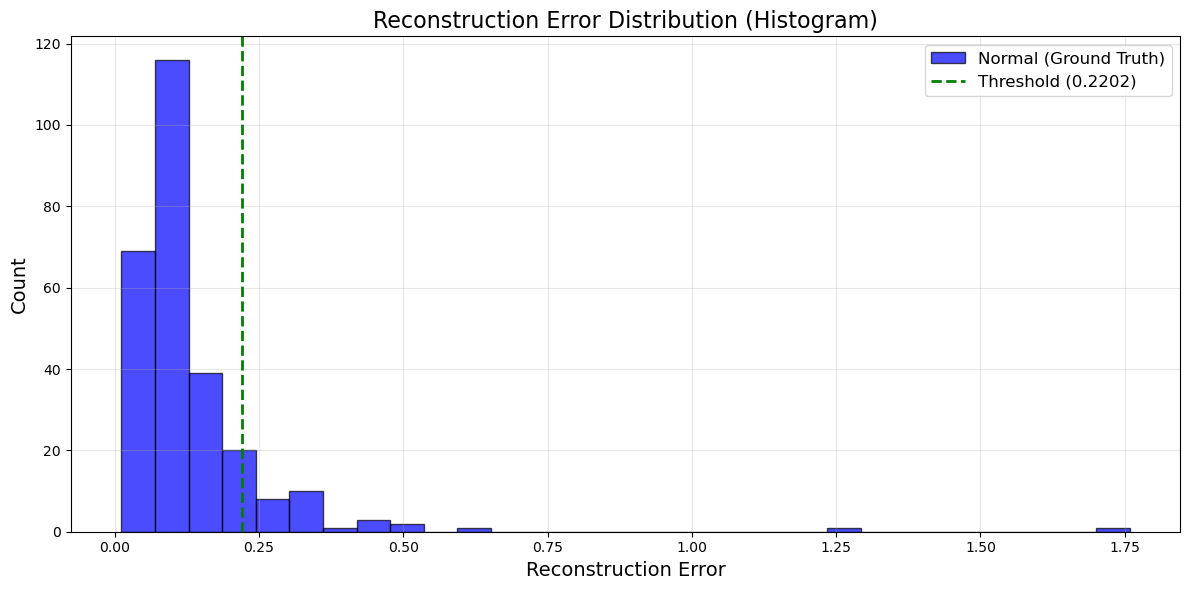

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Split reconstruction errors by ground truth labels
normal_errors = np.array([e for e, l in zip(eval_errors, eval_labels) if l == 0])  # Normal
anomaly_errors = np.array([e for e, l in zip(eval_errors, eval_labels) if l == 1])  # Anomalous

# Plot histogram of reconstruction errors
plt.figure(figsize=(12, 6))

# Use histograms with bins for raw data distribution
plt.hist(normal_errors, bins=30, alpha=0.7, label="Normal (Ground Truth)", color="blue", edgecolor="black")
# plt.hist(anomaly_errors, bins=30, alpha=0.7, label="Anomaly (Ground Truth)", color="red", edgecolor="black")

# Add threshold line
plt.axvline(threshold, color="green", linestyle="--", linewidth=2, label=f"Threshold ({threshold:.4f})")

# Add labels and legend
plt.title("Reconstruction Error Distribution (Histogram)", fontsize=16)
plt.xlabel("Reconstruction Error", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()


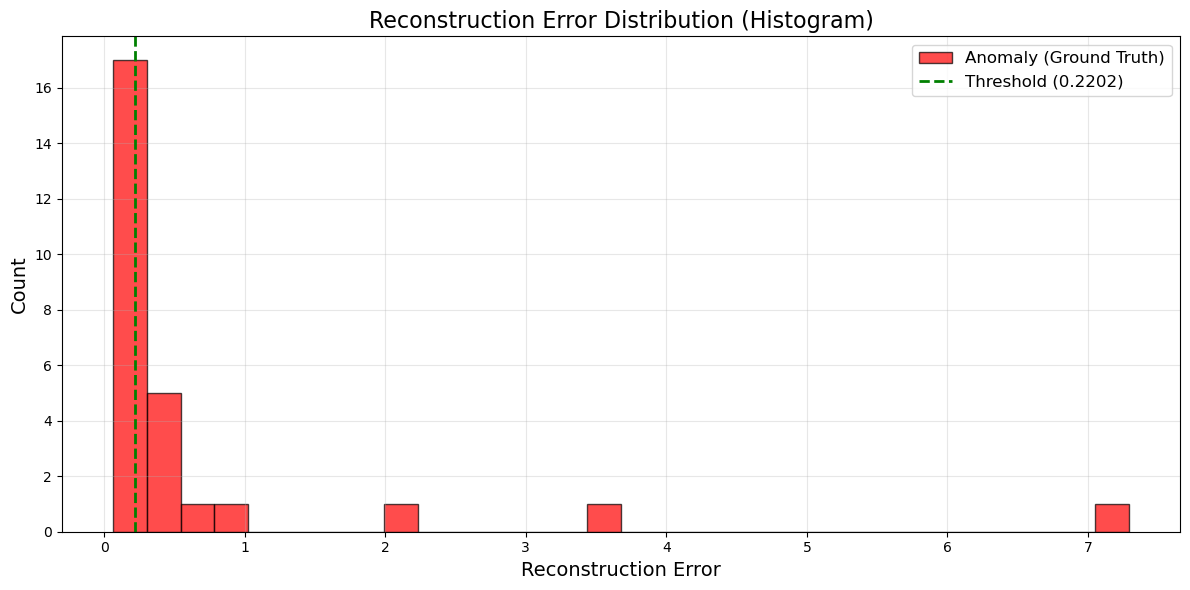

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Split reconstruction errors by ground truth labels
normal_errors = np.array([e for e, l in zip(eval_errors, eval_labels) if l == 0])  # Normal
anomaly_errors = np.array([e for e, l in zip(eval_errors, eval_labels) if l == 1])  # Anomalous

# Plot histogram of reconstruction errors
plt.figure(figsize=(12, 6))

# Use histograms with bins for raw data distribution
# plt.hist(normal_errors, bins=30, alpha=0.7, label="Normal (Ground Truth)", color="blue", edgecolor="black")
plt.hist(anomaly_errors, bins=30, alpha=0.7, label="Anomaly (Ground Truth)", color="red", edgecolor="black")

# Add threshold line
plt.axvline(threshold, color="green", linestyle="--", linewidth=2, label=f"Threshold ({threshold:.4f})")

# Add labels and legend
plt.title("Reconstruction Error Distribution (Histogram)", fontsize=16)
plt.xlabel("Reconstruction Error", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()


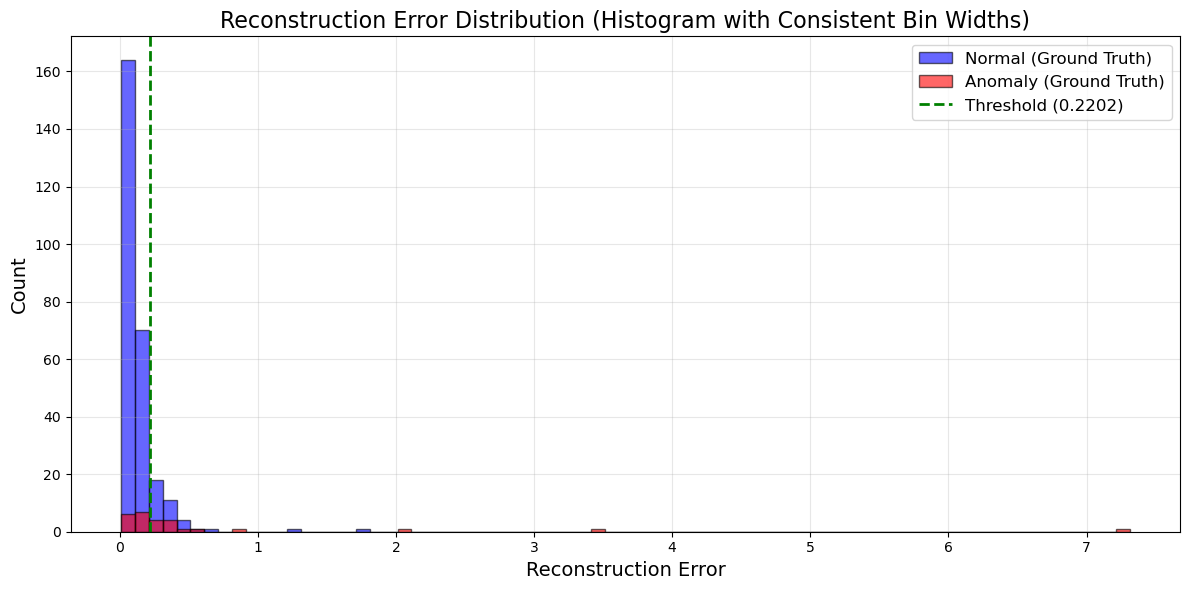

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Split reconstruction errors by ground truth labels
normal_errors = np.array([e for e, l in zip(eval_errors, eval_labels) if l == 0])  # Normal
anomaly_errors = np.array([e for e, l in zip(eval_errors, eval_labels) if l == 1])  # Anomalies

# Define a consistent range and number of bins
min_error = min(normal_errors.min(), anomaly_errors.min())
max_error = max(normal_errors.max(), anomaly_errors.max())
bin_width = 0.1  # Define the desired bin width
bins = np.arange(min_error, max_error + bin_width, bin_width)  # Generate bin edges

# Plot histograms with consistent bins
plt.figure(figsize=(12, 6))

plt.hist(normal_errors, bins=bins, color="blue", alpha=0.6, label="Normal (Ground Truth)", edgecolor="black")
plt.hist(anomaly_errors, bins=bins, color="red", alpha=0.6, label="Anomaly (Ground Truth)", edgecolor="black")

# Add threshold line
plt.axvline(threshold, color="green", linestyle="--", linewidth=2, label=f"Threshold ({threshold:.4f})")

# Add labels, title, and legend
plt.title("Reconstruction Error Distribution (Histogram with Consistent Bin Widths)", fontsize=16)
plt.xlabel("Reconstruction Error", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()


In [55]:
# Classify Evaluation Data Based on Threshold
eval_labels = []
predicted_labels = []

with torch.no_grad():
    for features, labels in minority_loader:
        reconstructed = autoencoder(features)
        errors = torch.mean((features - reconstructed) ** 2, dim=1).numpy()
        preds = (errors > threshold).astype(int)  # 1 for anomaly, 0 for normal
        eval_labels.extend(labels.numpy())
        predicted_labels.extend(preds)

# Generate Classification Report
print("Classification Report:")
print(classification_report(eval_labels, predicted_labels, target_names=["Class 0 (Normal)", "Class 1 (Anomaly)"]))


Classification Report:
                   precision    recall  f1-score   support

 Class 0 (Normal)       0.00      0.00      0.00         0
Class 1 (Anomaly)       1.00      0.42      0.59       118

         accuracy                           0.42       118
        macro avg       0.50      0.21      0.29       118
     weighted avg       1.00      0.42      0.59       118



/Users/saefurukawa/opt/anaconda3/envs/pai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saefurukawa/opt/anaconda3/envs/pai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saefurukawa/opt/anaconda3/envs/pai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu